In [1]:
import pandas as pd
from datetime import datetime,timedelta
import requests
import json
# Binance
def getCandles(symbol, interval, limit=0, startTime=None, endTime=None):
    url = 'https://www.binance.co/api/v1/klines?'
    params = {
        'symbol': symbol,
        'interval': interval
    }
    if limit:
        params['limit'] = limit
    if startTime:
        params['startTime'] = int(startTime.timestamp()*1000)
    if endTime:
        params['endTime'] = int(endTime.timestamp()*1000)
    r = requests.get(url, headers={
            'Content-Type': 'application/x-www-form-urlencoded',
            'Accept': 'application/json'
        }, params = params,timeout=10)
    text = json.loads(r.content)
    df = pd.DataFrame(text, columns=[
        "opentime", "open", "high", "low", "close", "volume","closetime","Quote","trades","buybase","buyquote","ignore"])
    df["datetime"] = df["opentime"].map(lambda x: datetime.fromtimestamp(x / 1000).strftime("%Y%m%d %H:%M:%S"))
    return df
# interval available: 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

In [2]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

# MA

In [74]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 5; slowPeriod = 20
    signalMaPeriod = 5
    stopRatio = 0.05
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-0.9*self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+2*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+1.1*self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------

    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x1bf95ec048>, <__main__.MultiFrameMaStrategy object at 0x1bf86950f0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x1bf95ec400>, <__main__.MultiFrameMaStrategy object at 0x1bf86950f0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x1bf95ec488>, <__main__.MultiFrameMaStrategy object at 0x1bf86950f0>)
2018-12-23 19:06:40.252676	开始回测
2018-12-23 19:06:40.252832	策略初始化
2018-12-23 19:06:40.255439	载入历史数据。数据范围:[20180602 04:00,20180610 12:00)
2018-12-23 19:06:40.942645	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 19:06:40.946487	载入完成，数据量：12000
2018-12-23 19:06:40.946760	策略初始化完成
2018-12-23 19:06:40.946809	策略启动完成
2018-12-23 19:06:40.946895	开始回放回测数据,回测范围:[20180610 12:00,20181210 12:00)
2018-12-23 19:06:40.97

Traceback (most recent call last):
  File "/Users/user/anaconda3/lib/python3.6/site-packages/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/user/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7261.03, 'high': 7304.95, 'low': 7258.27, 'close': 7304.87, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 465.64272700000004, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7261.03,

2018-08-14 01:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-15 04:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-08-16 08:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-16 19:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-08-17 07:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-17 12:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-08-18 15:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-19 17:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-08-20 17:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-21 04:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-08-21 07:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-21 18:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-08-23 00:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-08-23 1

2018-11-01 01:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-01 22:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-11-02 03:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-02 21:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-11-02 23:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-03 13:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-11-04 09:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-04 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-11-04 16:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-05 18:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-11-06 01:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-06 02:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-11-06 10:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-11-06 1

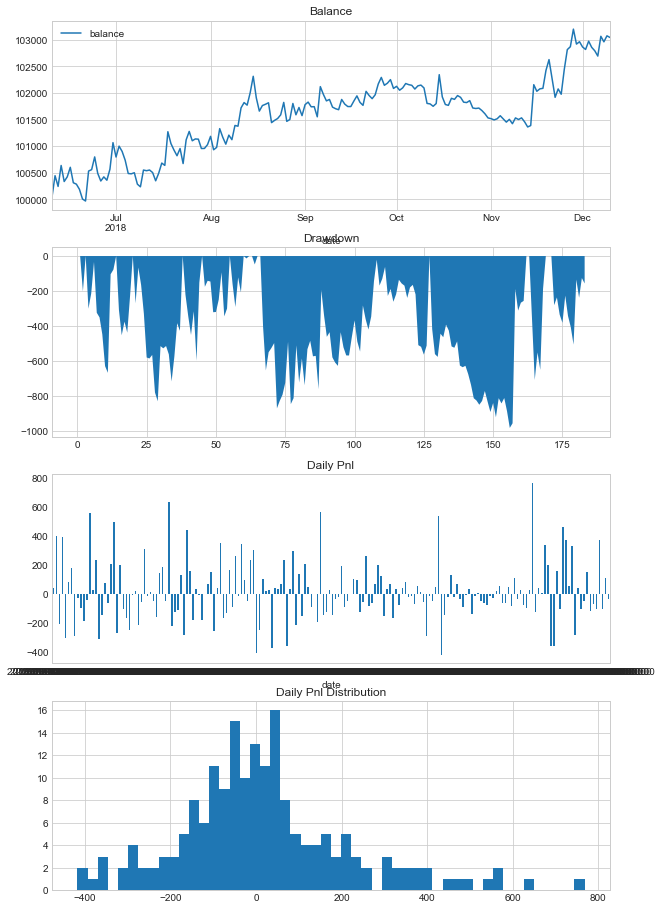

2018-12-23 19:07:21.596452	计算回测结果
2018-12-23 19:07:21.635310	------------------------------
2018-12-23 19:07:21.635483	第一笔交易：	2018-06-11 21:15:00
2018-12-23 19:07:21.635548	最后一笔交易：	2018-12-10 11:58:00
2018-12-23 19:07:21.635602	总交易次数：	265
2018-12-23 19:07:21.635660	总盈亏：	3,043.19
2018-12-23 19:07:21.635717	最大回撤: 	-1,107.51
2018-12-23 19:07:21.635765	平均每笔盈利：	11.48
2018-12-23 19:07:21.635825	平均每笔滑点：	0.0
2018-12-23 19:07:21.635937	平均每笔佣金：	6.34
2018-12-23 19:07:21.635983	胜率		32.08%
2018-12-23 19:07:21.636027	盈利交易平均值	181.24
2018-12-23 19:07:21.636070	亏损交易平均值	-68.68
2018-12-23 19:07:21.636113	盈亏比：	2.64


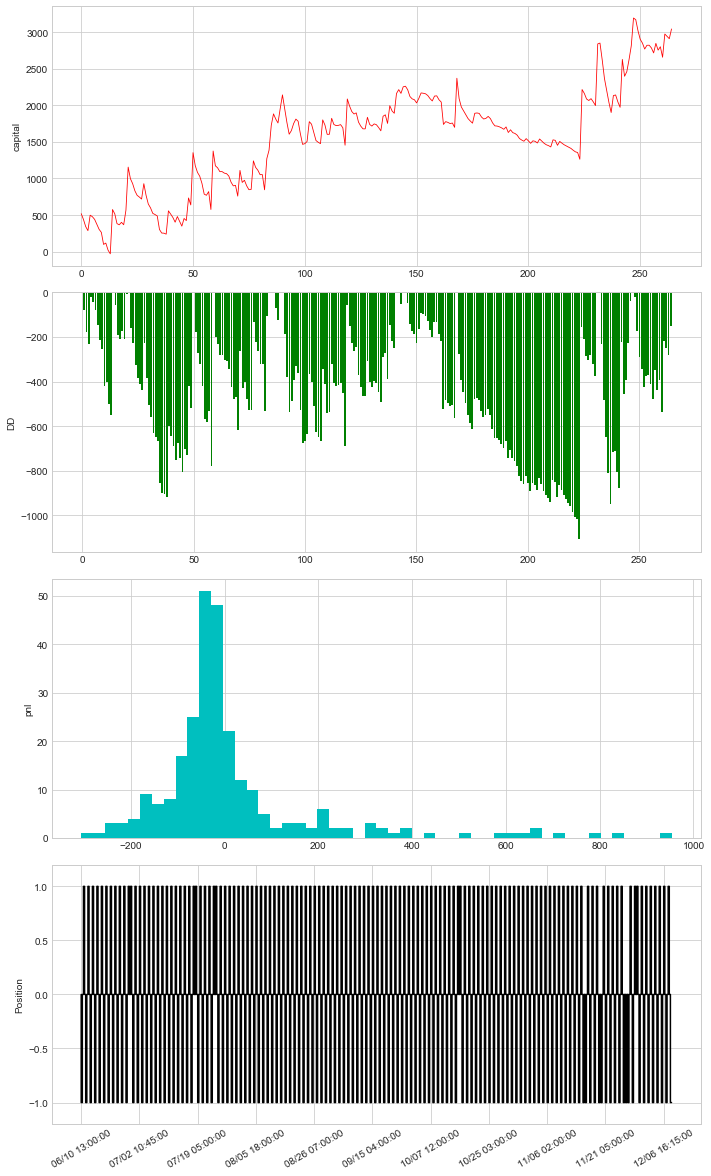

2018-12-23 19:07:22.675577	计算按日统计结果


In [75]:
MultiFrameMaDf = runBacktesting(MultiFrameMaStrategy, {'symbolList':['BTCUSDT:binance']} , '20180610 12:00', \
                            '20181210 12:00', 0.002, 5/10000)

# RSI

In [85]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class RsiTrendStrategy(CtaTemplate):
    className = 'RsiTrendStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 30; slowPeriod = 60
    signalMaPeriod = 20
    
    stopRatio = 0.03
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        rsi = ta.RSI(am15.close, self.signalMaPeriod)

        rsiOverbought = (rsi[-1]>70) and (rsi[-2]<=70) # 超买
        rsiOversold = (rsi[-1]<30) and (rsi[-2]>=30) # 超卖
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if rsiOversold and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if rsiOverbought and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function RsiTrendStrategy.on60MinBar at 0x1c09855f28>, <__main__.RsiTrendStrategy object at 0x1c0984d860>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function RsiTrendStrategy.on15MinBar at 0x1c09855e18>, <__main__.RsiTrendStrategy object at 0x1c0984d860>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function RsiTrendStrategy.onBar at 0x1c09855ea0>, <__main__.RsiTrendStrategy object at 0x1c0984d860>)
2018-12-23 19:10:34.130637	开始回测
2018-12-23 19:10:34.130698	策略初始化
2018-12-23 19:10:34.132349	载入历史数据。数据范围:[20180602 04:00,20180610 12:00)
2018-12-23 19:10:34.957013	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 19:10:34.964741	载入完成，数据量：12000
2018-12-23 19:10:34.965387	策略初始化完成
2018-12-23 19:10:34.965461	策略启动完成
2018-12-23 19:10:34.965542	开始回放回测数据,回测范围:[20180610 12:00,20181210 12:00)
2018-12-23 19:10:34.991880	载入历史数据。数据范围:[201806

Traceback (most recent call last):
  File "/Users/user/anaconda3/lib/python3.6/site-packages/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/user/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7261.03, 'high': 7304.95, 'low': 7258.27, 'close': 7304.87, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 465.64272700000004, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7261.03,

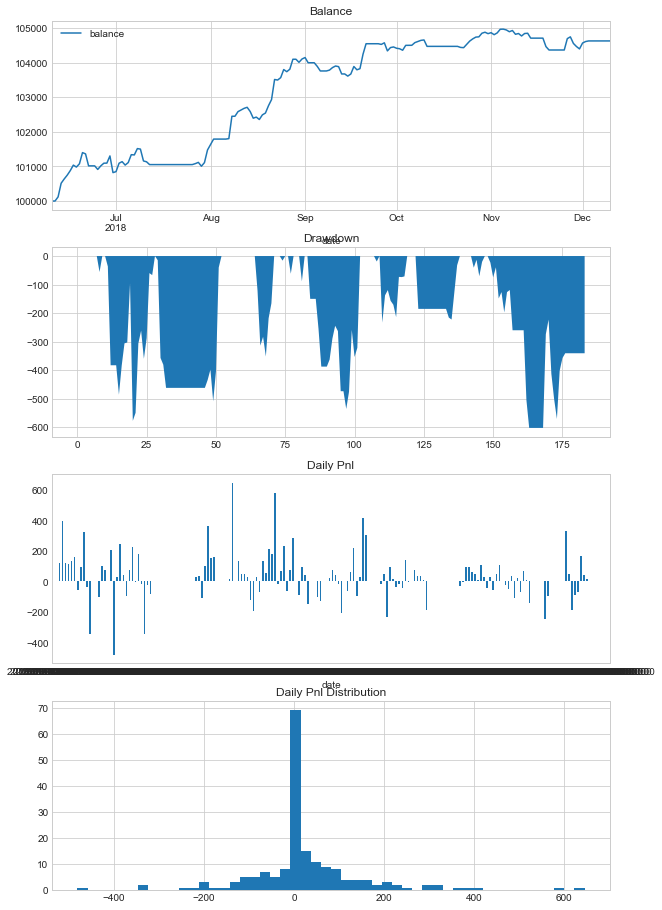

2018-12-23 19:11:14.347643	计算回测结果
2018-12-23 19:11:14.358855	------------------------------
2018-12-23 19:11:14.359117	第一笔交易：	2018-06-14 00:26:00
2018-12-23 19:11:14.359193	最后一笔交易：	2018-12-03 23:14:00
2018-12-23 19:11:14.359258	总交易次数：	49
2018-12-23 19:11:14.359324	总盈亏：	4,622.79
2018-12-23 19:11:14.359386	最大回撤: 	-624.06
2018-12-23 19:11:14.359449	平均每笔盈利：	94.34
2018-12-23 19:11:14.359506	平均每笔滑点：	0.0
2018-12-23 19:11:14.359625	平均每笔佣金：	6.15
2018-12-23 19:11:14.359716	胜率		63.27%
2018-12-23 19:11:14.359777	盈利交易平均值	253.52
2018-12-23 19:11:14.359852	亏损交易平均值	-179.8
2018-12-23 19:11:14.359910	盈亏比：	1.41


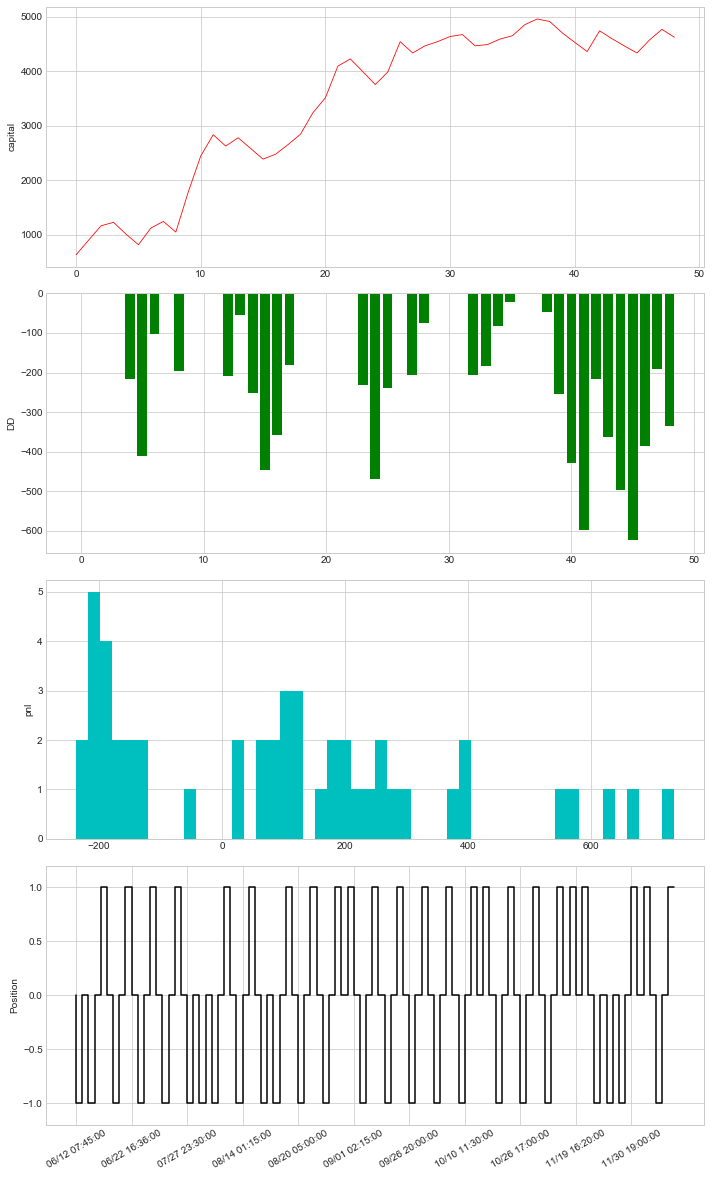

2018-12-23 19:11:15.113604	计算按日统计结果


In [86]:
rsiTrendDf = runBacktesting(RsiTrendStrategy, {'symbolList':['BTCUSDT:binance']} , '20180610 12:00', \
                            '20181210 12:00', 0.002, 5/10000)

In [98]:
PortfolioDf = MultiFrameMaDf+rsiTrendDf

In [103]:
PortfolioDf = PortfolioDf.dropna()

# 创建回测引擎，并设置组合回测初始资金后，显示结果
engine = BacktestingEngine()
engine.setCapital(1000000)
dfp, result = engine.calculateDailyStatistics(PortfolioDf)

In [102]:
PortfolioStrategy=RsiTrendStrategy+MultiFrameMaStrategy

TypeError: unsupported operand type(s) for +: 'type' and 'type'

In [104]:
result

{'startDate': Timestamp('2018-06-10 00:00:00'),
 'endDate': Timestamp('2018-12-10 00:00:00'),
 'totalDays': 184,
 'profitDays': 91,
 'lossDays': 90,
 'endBalance': 1007667.75433,
 'maxDrawdown': -724.6752400000114,
 'maxDdPercent': -0.07197687199206712,
 'totalNetPnl': 7667.754330000001,
 'dailyNetPnl': 41.67257788043479,
 'totalCommission': 1979.0916700000005,
 'dailyCommission': 10.755932989130438,
 'totalSlippage': 1.254000000000001,
 'dailySlippage': 0.006815217391304353,
 'totalTurnover': 3958183.339999999,
 'dailyTurnover': 21511.865978260863,
 'totalTradeCount': 627,
 'dailyTradeCount': 3.407608695652174,
 'totalReturn': 0.7667754330000109,
 'annualizedReturn': 1.0001418691304491,
 'dailyReturn': 0.004126662219799718,
 'returnStd': 0.022609767865086124,
 'sharpeRatio': 2.827537929283691}